In [1]:
# pip install duckdb
# pip install jupysql
# pip install notebook
# pip install tabulate
# pip install sqlalchemy

Note: you may need to restart the kernel to use updated packages.


In [1]:
# If on windows, this only works if you're running Jupyter as an admin
# pip install duckdb-engine

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
import sqlalchemy
from datetime import date
import json
import pathlib
# import importlib
%load_ext sql

In [3]:
# Set up SQL connection
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

# Change the billboard_observation_date!

In [4]:
current_date = date.today().strftime('%Y-%m-%d')
billboard_observation_date = '2024-05-21'

In [5]:
# Replace with your filepath. Forward slashes work for both Mac and Windows
%sql duckdb:///C:/Users/Admin/billboard/raw_db.duckdb

In [6]:
# Test connection
%sql USE raw_db;
%sql USE raw_db.billboard;

,Success


# Update upload/rank_by_name

In [7]:
# Update this for this week's rankings in upload/rank_by_name.py
# This is easier in an IDE that allows opt+arrow_key to move lines up and down

In [8]:
# TODO: figure out importlib.reload() here so I don't have to kill the kernel to reload
# from upload.rank_by_name import rankings
from upload.backfill_rank_by_name import rankings

if len(rankings) != 50:
    print(f'{len(rankings)} rankings, but expected 50')

rankings[:5] + ['...'] + rankings[45:]

['I Had Some Help',
 'A Bar Song (Tipsy)',
 'I Remember Everything',
 'Miles On It',
 'Austin',
 '...',
 "This Town's Been Too Good To Us",
 "The Good I'll Do",
 'Worst Way',
 'Jolene',
 "Should've Been A Cowboy"]

In [9]:
%%sql df_song_labeled <<
SELECT
    ss.song_id
    , ss.song_name
    , art.artist_name
    , s2a.relationship_type
    , ss.untracked_weeks_on_chart
FROM song ss
LEFT JOIN song_to_artist s2a
    ON ss.song_id = s2a.song_id
LEFT JOIN artist art
    ON s2a.artist_id = art.artist_id
;

In [11]:
existing_song_to_rank = {}
new_song_to_rank = {}
for song, rank_ix in zip(rankings, range(1,51)):
    n_rows = df_song_labeled[df_song_labeled['song_name'] == song]['song_id'].count()
    if n_rows == 0:
        new_song_to_rank[song] = rank_ix
    else:
        print(df_song_labeled.loc[df_song_labeled['song_name'] == song].to_markdown())
        song_id = input("Please enter the song_id or 'New Song'\n")

        if song_id == '': # hit enter to take the most common song ID
            song_id = int(
                df_song_labeled.loc[
                    df_song_labeled['song_name'] == song
                ]['song_id'].mode()
            )
        
        if str(song_id).lower() == 'new song':
            new_song_to_rank[song] = rank_ix
        else:
            existing_song_to_rank[int(song_id)] = rank_ix

|     |   song_id | song_name       | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|----:|----------:|:----------------|:--------------|:--------------------|---------------------------:|
|  22 |        38 | I Had Some Help | Morgan Wallen | Other main artist   |                          0 |
| 127 |        38 | I Had Some Help | Post Malone   | Lead artist         |                          0 |
Please enter the song_id or 'New Song'

|    |   song_id | song_name          | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|---:|----------:|:-------------------|:--------------|:--------------------|---------------------------:|
| 18 |        34 | A Bar Song (Tipsy) | Shaboozey     | Lead artist         |                          0 |
Please enter the song_id or 'New Song'

|     |   song_id | song_name             | artist_name     | relationship_type   |   untracked_weeks_on_chart |
|----:|----------:|:----------------------|:----------------|:----

Please enter the song_id or 'New Song'

|     |   song_id | song_name     | artist_name         | relationship_type   |   untracked_weeks_on_chart |
|----:|----------:|:--------------|:--------------------|:--------------------|---------------------------:|
| 102 |       126 | Wondering Why | The Red Clay Strays | Lead artist         |                          7 |
Please enter the song_id or 'New Song'

|     |   song_id | song_name      | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|----:|----------:|:---------------|:--------------|:--------------------|---------------------------:|
| 104 |       128 | II Most Wanted | Miley Cyrus   | Other main artist   |                          0 |
| 156 |       128 | II Most Wanted | Beyonce       | Lead artist         |                          0 |
Please enter the song_id or 'New Song'

|    |   song_id | song_name   | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|---:|----------:|:------------|:----

Please enter the song_id or 'New Song'

|     |   song_id | song_name        | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|----:|----------:|:-----------------|:--------------|:--------------------|---------------------------:|
| 114 |       138 | The Good I'll Do | Zach Bryan    | Lead artist         |                         15 |
Please enter the song_id or 'New Song'

|    |   song_id | song_name   | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|---:|----------:|:------------|:--------------|:--------------------|---------------------------:|
| 19 |        35 | Worst Way   | Riley Green   | Lead artist         |                          0 |
Please enter the song_id or 'New Song'

|     |   song_id | song_name   | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|----:|----------:|:------------|:--------------|:--------------------|---------------------------:|
| 181 |        18 | Jolene      |               |           

In [12]:
# Notes
# Need s2a for Jolene(18)

In [13]:
# Check that you have 50 songs
print(len(existing_song_to_rank), '+')
print(json.dumps(new_song_to_rank, indent = 2))

48 +
{
  "Wildflowers And Wild Horses": 14,
  "Cab In A Solo": 43
}


### Add artists on any new songs that aren't in the artist table yet to its CSV

  (s2a only) "Jolene"(18): Beyonce(3)
  "Wildflowers And Wild Horses": Lainey Wilson(11) +9,
  "Cab In A Solo": Scotty McCreery(77) +1

In [14]:
df_artist = pd.read_csv('source_data/artist.csv')

In [19]:
new_song_artists = [
    'Beyonce'
    , 'Lainey Wilson'
    , 'Scotty McCreery'
]
df_artist[df_artist['artist_name'].isin(new_song_artists)]

,artist_id,artist_name,pct_female,last_update
2,3,Beyonce,1.0,2024-08-23
10,11,Lainey Wilson,1.0,2024-08-23
76,77,Scotty McCreery,0,2024-09-15


In [16]:
df_artist['artist_id'].max()

76

In [17]:
df_artist = pd.concat(
    [
        df_artist
        , pd.DataFrame(
            np.array([
                [77, 'Scotty McCreery', 0, current_date]
            ])
            , columns = ['artist_id', 'artist_name', 'pct_female', 'last_update']
        )
    ]
    , ignore_index = True
)

In [18]:
df_artist.to_csv('source_data/artist.csv', index=False)
print('Done for', billboard_observation_date)

Done for 2024-05-21


### Add all new songs to the song table CSV

In [20]:
df_song_raw = pd.read_csv('source_data/song.csv')

In [21]:
max_song_id = df_song_raw['song_id'].max()
array_new_songs = []
for song_name in list(new_song_to_rank.keys()):
    max_song_id += 1
    array_new_songs += [[max_song_id, song_name, 0, current_date]]

array_new_songs

[[143, 'Wildflowers And Wild Horses', 0, '2024-09-15'],
 [144, 'Cab In A Solo', 0, '2024-09-15']]

In [22]:
df_song_raw = pd.concat(
    [
        df_song_raw
        , pd.DataFrame(
            np.array(array_new_songs)
            , columns = ['song_id', 'song_name', 'untracked_weeks_on_chart', 'last_update']
        )
    ]
    , ignore_index = True
)
df_song_raw[-len(array_new_songs)-1:]

,song_id,song_name,untracked_weeks_on_chart,last_update
141,142,Should've Been A Cowboy,0.0,2024-09-15
142,143,Wildflowers And Wild Horses,0,2024-09-15
143,144,Cab In A Solo,0,2024-09-15


In [23]:
# Adjust untracked weeks if they aren't zero
# Do not use in case of multiple songs with the same name
for song, untracked_weeks in [
    ('Wildflowers And Wild Horses', 9)
    , ("Cab In A Solo", 1)
]:
    df_song_raw.loc[
        df_song_raw['song_name'] == song
        , 'untracked_weeks_on_chart'
    ] = untracked_weeks

In [24]:
df_song_raw.to_csv('source_data/song.csv', index=False)
print('Done for', billboard_observation_date)

Done for 2024-05-21


#### Add all new songs to the song_to_artist table CSV

In [25]:
df_s2a_raw = pd.read_csv('source_data/song_to_artist.csv').fillna('')

#### Paste new songs list here
  (s2a only) "Jolene"(18): Beyonce(3)
  "Wildflowers And Wild Horses": Lainey Wilson(11) +9,
  "Cab In A Solo": Scotty McCreery(77) +1

In [26]:
array_new_s2a = []
for s2a in [ # song_id, artist_id, relationship_conjunction, relationship_index
    [18, 3, '', '']
    , [143, 11, '', '']
    , [144, 77, '', '']
]:
    if s2a[3] == '': # Only lead artists don't have a relationship index
        reln = 'Lead artist'
    elif s2a[2] == '': # Featured artists don't have an explicit relationship conjunction
        reln = 'Featured artist' 
    else:
        reln = 'Other main artist'
        
    array_new_s2a += [[
        '-'.join([str(s2a[0]), reln, str(s2a[3])])
        , s2a[0]
        , s2a[1]
        , reln
        , s2a[2]
        , s2a[3]
        , current_date
    ]]
    
array_new_s2a

[['18-Lead artist-', 18, 3, 'Lead artist', '', '', '2024-09-15'],
 ['143-Lead artist-', 143, 11, 'Lead artist', '', '', '2024-09-15'],
 ['144-Lead artist-', 144, 77, 'Lead artist', '', '', '2024-09-15']]

In [27]:
df_s2a_raw = pd.concat(
    [
        df_s2a_raw
        , pd.DataFrame(
            np.array(array_new_s2a)
            , columns = [
                'song_to_artist_pk'
                , 'song_id'
                , 'artist_id'
                , 'relationship_type'
                , 'relationship_conjunction'
                , 'relationship_index'
                , 'last_update'
            ]
        )
    ]
    , ignore_index = True
)
df_s2a_raw.tail(1)

,song_to_artist_pk,song_id,artist_id,relationship_type,relationship_conjunction,relationship_index,last_update
171,144-Lead artist-,144,77,Lead artist,,,2024-09-15


In [28]:
df_s2a_raw.to_csv('source_data/song_to_artist.csv', index=False)
print('Done for', billboard_observation_date)

Done for 2024-05-21


#### Convert new_song_to_rank to the id_to_rankix format of existing_song_to_rank
Then stack the two dicts of songs and insert to CSV with more info like current_date for last_update

In [29]:
all_song_to_rank = existing_song_to_rank.copy()
for song_name, rank in new_song_to_rank.items():
    songs = list(df_song_raw[df_song_raw['song_name'] == song_name]['song_id'])
    
    if len(songs) == 1:
        song_id = songs[0]
    elif len(songs) > 1:
        song_id = int(input(f'{str(songs)}: Choose ID of song actually at rank {rank}\n'))
    else:
        raise Exception(f'The song at rank {rank} is missing from the song CSV')
    
    all_song_to_rank[int(song_id)] = rank

array_new_ranking = [
    [
        '-'.join([billboard_observation_date, str(rank)])
        , billboard_observation_date
        , rank
        , song_id
        , current_date
    ]
    for song_id, rank
    in all_song_to_rank.items()
]

array_new_ranking[45:] # should be 5 rows, new songs come at end

[['2024-05-21-48', '2024-05-21', 48, 35, '2024-09-15'],
 ['2024-05-21-49', '2024-05-21', 49, 18, '2024-09-15'],
 ['2024-05-21-50', '2024-05-21', 50, 142, '2024-09-15'],
 ['2024-05-21-14', '2024-05-21', 14, 143, '2024-09-15'],
 ['2024-05-21-43', '2024-05-21', 43, 144, '2024-09-15']]

In [30]:
pd.concat(
    [
        pd.read_csv('source_data/billboard_ranking.csv').fillna('')
        , pd.DataFrame(
            np.array(array_new_ranking)
            , columns = [
                'billboard_ranking_pk'
                , 'billboard_observation_date'
                , 'billboard_rank'
                , 'song_id'
                , 'last_update'
            ]
        )
    ]
    , ignore_index = True
).to_csv('source_data/billboard_ranking.csv', index=False)

print('Done for', billboard_observation_date)

Done for 2024-05-21


## Push to duckdb

In [31]:
# TODO: instead of purging and rebuilding, use the raw data to run updates
%sql --close duckdb:///C:/Users/Admin/billboard/raw_db.duckdb --quiet
pathlib.Path('raw_db.duckdb').unlink(missing_ok = True)

TODO: integrate into jupyter using `%python`

In a command terminal
- `python table_configs/run_schema_configs.py billboard_schema.sql`
- `python table_configs/run_table_configs.py`
- `python main.py`

## Run the ranking SQL script

In [44]:
weeks_lookback = 13 # Arbitrary lookback

with duckdb.connect('raw_db.duckdb') as conn:
    for weeks_ago in range(weeks_lookback):
        if weeks_ago == 0:
            with open('analysis/artist_ranking.sql') as sql_file:
                artist_ranking = conn.sql(sql_file.read().format(weeks_ago = str(weeks_ago)))
                df_artist_ranking = pd.DataFrame(
                    data=artist_ranking.fetchall()
                    , columns=artist_ranking.columns
                )

        else: # Have to close and reopen file between executions for fetchall() to work
            with open('analysis/artist_ranking.sql') as sql_file:
                prev_artist_ranking = conn.sql(sql_file.read().format(weeks_ago = str(weeks_ago)))
                df_artist_ranking = pd.concat([
                    df_artist_ranking
                    , pd.DataFrame(
                        data=prev_artist_ranking.fetchall()
                        , columns=artist_ranking.columns
                    )
                ])

In [45]:
# TODO make this show NA() for lookback windows with zero artist song credits
df_artist_ranking_over_time = df_artist_ranking.pivot(
    index = 'artist_name'
    , columns = 'weeks_ago'
    , values = 'artist_rank'
).sort_values(0)

df_artist_ranking_over_time.loc[:, -3:][:30]

weeks_ago,-3,-2,-1,0
artist_name,,,,
Zach Bryan,1,1,1,1
Post Malone,8,2,2,2
Morgan Wallen,2,3,3,3
Luke Combs,3,4,4,4
Jelly Roll,5,6,5,5
Megan Moroney,4,5,6,6
Koe Wetzel,6,7,7,7
Bailey Zimmerman,7,8,8,8
Tucker Wetmore,10,9,9,9


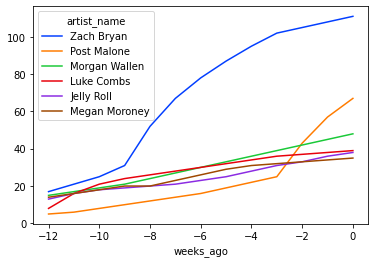

In [46]:
graph = sns.lineplot(
    data = df_artist_ranking.pivot(
        index = 'artist_name'
        , columns = 'weeks_ago'
        , values = 'recent_weeks_main_artist'
      ).loc[
        df_artist_ranking_over_time[0].keys() # maintain order from rank
      ][:6].fillna(np.inf).T
    , dashes = False
    #, markers = ['.'] * n_cols # TODO define new cols
    , palette = 'bright'
)
# title = 'Number of weeks as main artist'
# size = scale up plot size, then scale up number of lines

In [47]:
# Current artist rankings
pd.set_option('display.max_rows', 100)
cols = list(df_artist_ranking.columns)
col_nums = { col:ix for (col,ix) in zip(cols, range(len(cols))) }
df_artist_ranking_compact = df_artist_ranking.rename(columns = col_nums)
df_artist_ranking_compact.loc[ :, 1 : len(cols) - 2 ][df_artist_ranking['weeks_ago'] == 0]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,Zach Bryan,0,111,111,111,150,150,150,22,22,22,22,22,22,3.0,3.0,3.0,3.0,2024-05-21
1,Post Malone,0,67,67,67,67,67,67,18,18,18,18,18,18,1.0,1.0,1.0,1.0,2024-05-21
2,Morgan Wallen,0,31,48,60,43,60,72,3,4,5,3,4,5,1.0,1.0,1.0,1.0,2024-05-21
3,Luke Combs,0,39,39,47,87,87,95,9,9,11,10,10,12,3.0,3.0,3.0,3.0,2024-05-21
4,Jelly Roll,0,26,38,58,28,55,76,5,7,9,5,7,9,9.0,9.0,9.0,9.0,2024-05-21
5,Megan Moroney,0,33,35,35,53,59,59,5,6,6,5,6,6,21.0,21.0,21.0,21.0,2024-05-21
6,Koe Wetzel,0,34,34,34,34,34,34,3,3,3,3,3,3,8.0,8.0,8.0,8.0,2024-05-21
7,Bailey Zimmerman,0,29,29,29,35,35,35,4,4,4,4,4,4,7.0,7.0,7.0,7.0,2024-05-21
8,Tucker Wetmore,0,27,27,27,27,27,27,3,3,3,3,3,3,16.0,16.0,16.0,16.0,2024-05-21
9,Dylan Scott,0,18,27,27,26,41,41,2,3,3,2,3,3,35.0,35.0,35.0,35.0,2024-05-21


In [37]:
with duckdb.connect('raw_db.duckdb') as conn:
    print(conn.sql(
        """
        SELECT billboard_observation_date, COUNT(1) n
        FROM raw_db.billboard.billboard_ranking
        GROUP BY 1
        ORDER BY 1 DESC
        """
    ))

┌────────────────────────────┬───────┐
│ billboard_observation_date │   n   │
│            date            │ int64 │
├────────────────────────────┼───────┤
│ 2024-09-10                 │    50 │
│ 2024-09-05                 │    50 │
│ 2024-08-27                 │    50 │
│ 2024-08-23                 │    50 │
│ 2024-08-13                 │    50 │
│ 2024-08-07                 │    50 │
│ 2024-07-31                 │    50 │
│ 2024-07-23                 │    50 │
│ 2024-07-16                 │    50 │
│ 2024-07-10                 │    50 │
│ 2024-07-02                 │    50 │
│ 2024-06-25                 │    50 │
│ 2024-06-18                 │    50 │
│ 2024-06-11                 │    50 │
│ 2024-06-04                 │    50 │
│ 2024-05-29                 │    50 │
│ 2024-05-21                 │    50 │
├────────────────────────────┴───────┤
│ 17 rows                  2 columns │
└────────────────────────────────────┘



In [38]:
# TODO: Set comparison_observation_date as num weeks back, not specific date
current_observation_date = '2024-06-25' # or current_date
comparison_observation_date = '2024-06-18'

with duckdb.connect('raw_db.duckdb') as conn:
    with open('analysis/removed_songs.sql') as sql_file:
        removed_songs = conn.sql(
            sql_file.read().format(
                current_observation_date
                , comparison_observation_date
            )
        )
    print(removed_songs)

┌─────────┬────────────────────────┬────────────────┐
│ song_id │       song_name        │ ranking_before │
│  int32  │        varchar         │     int32      │
├─────────┼────────────────────────┼────────────────┤
│     126 │ Wondering Why          │             23 │
│     127 │ Spin You Around (1/24) │             25 │
│      45 │ Wanna Be Loved         │             41 │
│     128 │ II Most Wanted         │             42 │
│     129 │ Hell Or High Water     │             47 │
│      46 │ Maxed Out              │             49 │
│     130 │ Damn Near Normal       │             50 │
└─────────┴────────────────────────┴────────────────┘



# Scratch work to get song sparklines

In [ ]:
# TODO add a measurement start date column for Friday of each week based on observation date

In [48]:
%sql duckdb:///C:/Users/Admin/billboard/raw_db.duckdb

In [49]:
%%sql df_a_song <<
SELECT
    br.billboard_observation_date
    , br.song_id
    , ss.song_name
    , br.billboard_rank
FROM raw_db.billboard.billboard_ranking br
LEFT JOIN raw_db.billboard.song ss
    ON br.song_id = ss.song_id
WHERE br.song_id IN (63, 64) -- # Out Of Oklahoma, Guy For That as examples
ORDER BY 1 ASC
;

In [50]:
df_a_song

,billboard_observation_date,song_id,song_name,billboard_rank
0,2024-07-31,63,Out Of Oklahoma,45
1,2024-08-07,64,Guy For That,7
2,2024-08-07,63,Out Of Oklahoma,43
3,2024-08-13,64,Guy For That,12
4,2024-08-13,63,Out Of Oklahoma,41
5,2024-08-23,64,Guy For That,12
6,2024-08-23,63,Out Of Oklahoma,40
7,2024-08-27,64,Guy For That,7
8,2024-09-05,64,Guy For That,11
9,2024-09-10,64,Guy For That,12


In [51]:
%sql --close duckdb:///C:/Users/Admin/billboard/raw_db.duckdb --quiet

In [52]:
df_a_song.pivot(
        index='billboard_observation_date'
        , columns='song_name'
        , values='billboard_rank'
    ).fillna(np.inf)

song_name,Guy For That,Out Of Oklahoma
billboard_observation_date,,
2024-07-31,inf,45.0
2024-08-07,7.0,43.0
2024-08-13,12.0,41.0
2024-08-23,12.0,40.0
2024-08-27,7.0,inf
2024-09-05,11.0,inf
2024-09-10,12.0,50.0


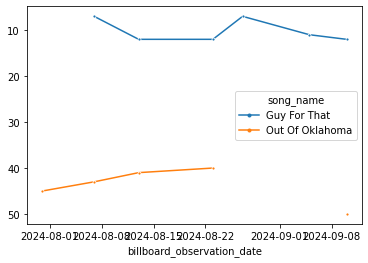

In [53]:
n_lines = 2 # TODO use df.count()

# TODO scale up size
# TODO a line for every song by an artist
# TODO loop through artists
# TODO dash type based on s2a relationship type
graph = sns.lineplot(
    data = df_a_song.pivot(
        index='billboard_observation_date'
        , columns='song_name'
        , values='billboard_rank'
    ).fillna(np.inf) # hide hidden data // TODO: show points with null immediately before and after
    , markers=['.'] * n_lines
    , dashes=False
    # , hue='k' # Not working with error 'cannot be assigned with wide-form data'
)
graph.axes.invert_yaxis()